# MitoEM2 Dataset Exploration

This notebook provides exploratory data analysis (EDA) of the MitoEM2
dataset for mitochondria segmentation across 8 cell types.

## Contents
1. Enumerate datasets and inspect metadata
2. Visualize EM slices and all label classes (background, mitochondria, boundary)
3. Per-dataset label distribution
4. Resolution and cross-dataset comparison

In [1]:
import sys
sys.path.insert(0, '..')

import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path

from neurons.preprocessors import NFTYPreprocessor

# ---------- Matplotlib defaults: LaTeX font, tab20, aspect=equal ----------
matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

CMAP_LABELS = plt.cm.tab20

# Dedicated colormap for MitoEM2 labels: bg=black, mito=green, boundary=red
MITO_COLORS = ListedColormap(['black', '#2ca02c', '#d62728'])

nfty = NFTYPreprocessor()

%matplotlib inline

## 1. Enumerate Datasets and Inspect Metadata

MitoEM2 provides 8 datasets, each with nnU-Net directory structure:
- `imagesTr/` -- training EM volumes (NIfTI)
- `labelsTr/` -- training labels (NIfTI): 0=background, 1=mitochondria, 2=boundary
- `imagesTs/` -- test EM volumes
- `labelsTs/` -- test labels
- `dataset.json` -- metadata

Set `DATA_ROOT` to the directory containing the MitoEM2 datasets.

In [2]:
DATA_ROOT = Path('../data/mitoem2')

ALL_DATASETS = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir() and d.name.startswith('Dataset')])

print(f'Found {len(ALL_DATASETS)} datasets in {DATA_ROOT}\n')

metadata = {}
for ds_dir in ALL_DATASETS:
    json_path = ds_dir / 'dataset.json'
    if json_path.exists():
        with open(json_path) as f:
            meta = json.load(f)
        metadata[ds_dir.name] = meta
        print(f'{ds_dir.name}:')
        print(f'  labels     : {meta.get("labels", {})}')
        print(f'  spacing    : {meta.get("spacing", [])}')
        print(f'  numTraining: {meta.get("numTraining", "?")}')
        print(f'  numTest    : {meta.get("numTest", "?")}')
        print()
    else:
        print(f'{ds_dir.name}: dataset.json not found')

Found 8 datasets in ../data/mitoem2

Dataset001_ME2-Beta:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [16, 16, 16]
  numTraining: 4
  numTest    : 3

Dataset002_ME2-Jurkat:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [16, 16, 16]
  numTraining: 2
  numTest    : 1

Dataset003_ME2-Macro:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [16, 16, 16]
  numTraining: 1
  numTest    : 1

Dataset004_ME2-Mossy:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [8, 8, 30]
  numTraining: 3
  numTest    : 2

Dataset005_ME2-Podo:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [16, 16, 16]
  numTraining: 2
  numTest    : 1

Dataset006_ME2-Pyra:
  labels     : {'background': 0, 'mitochondria': 1, 'boundary': 2}
  spacing    : [8, 8, 30]
  numTraining: 17
  numTest    : 1

Dataset007_ME2-Sperm:
  labels     : {'background': 0, '

## 2. Visualize EM Slices and All Label Classes

For each dataset we show the first training volume:
- Row 1: EM image (grayscale)
- Row 2: Full label map (background=black, mitochondria=green, boundary=red)
- Row 3: Mitochondria only (binary)
- Row 4: Boundary only (binary)

Dataset001_ME2-Beta: me2-beta_train01_0000.nii.gz  shape=(760, 699, 1097)


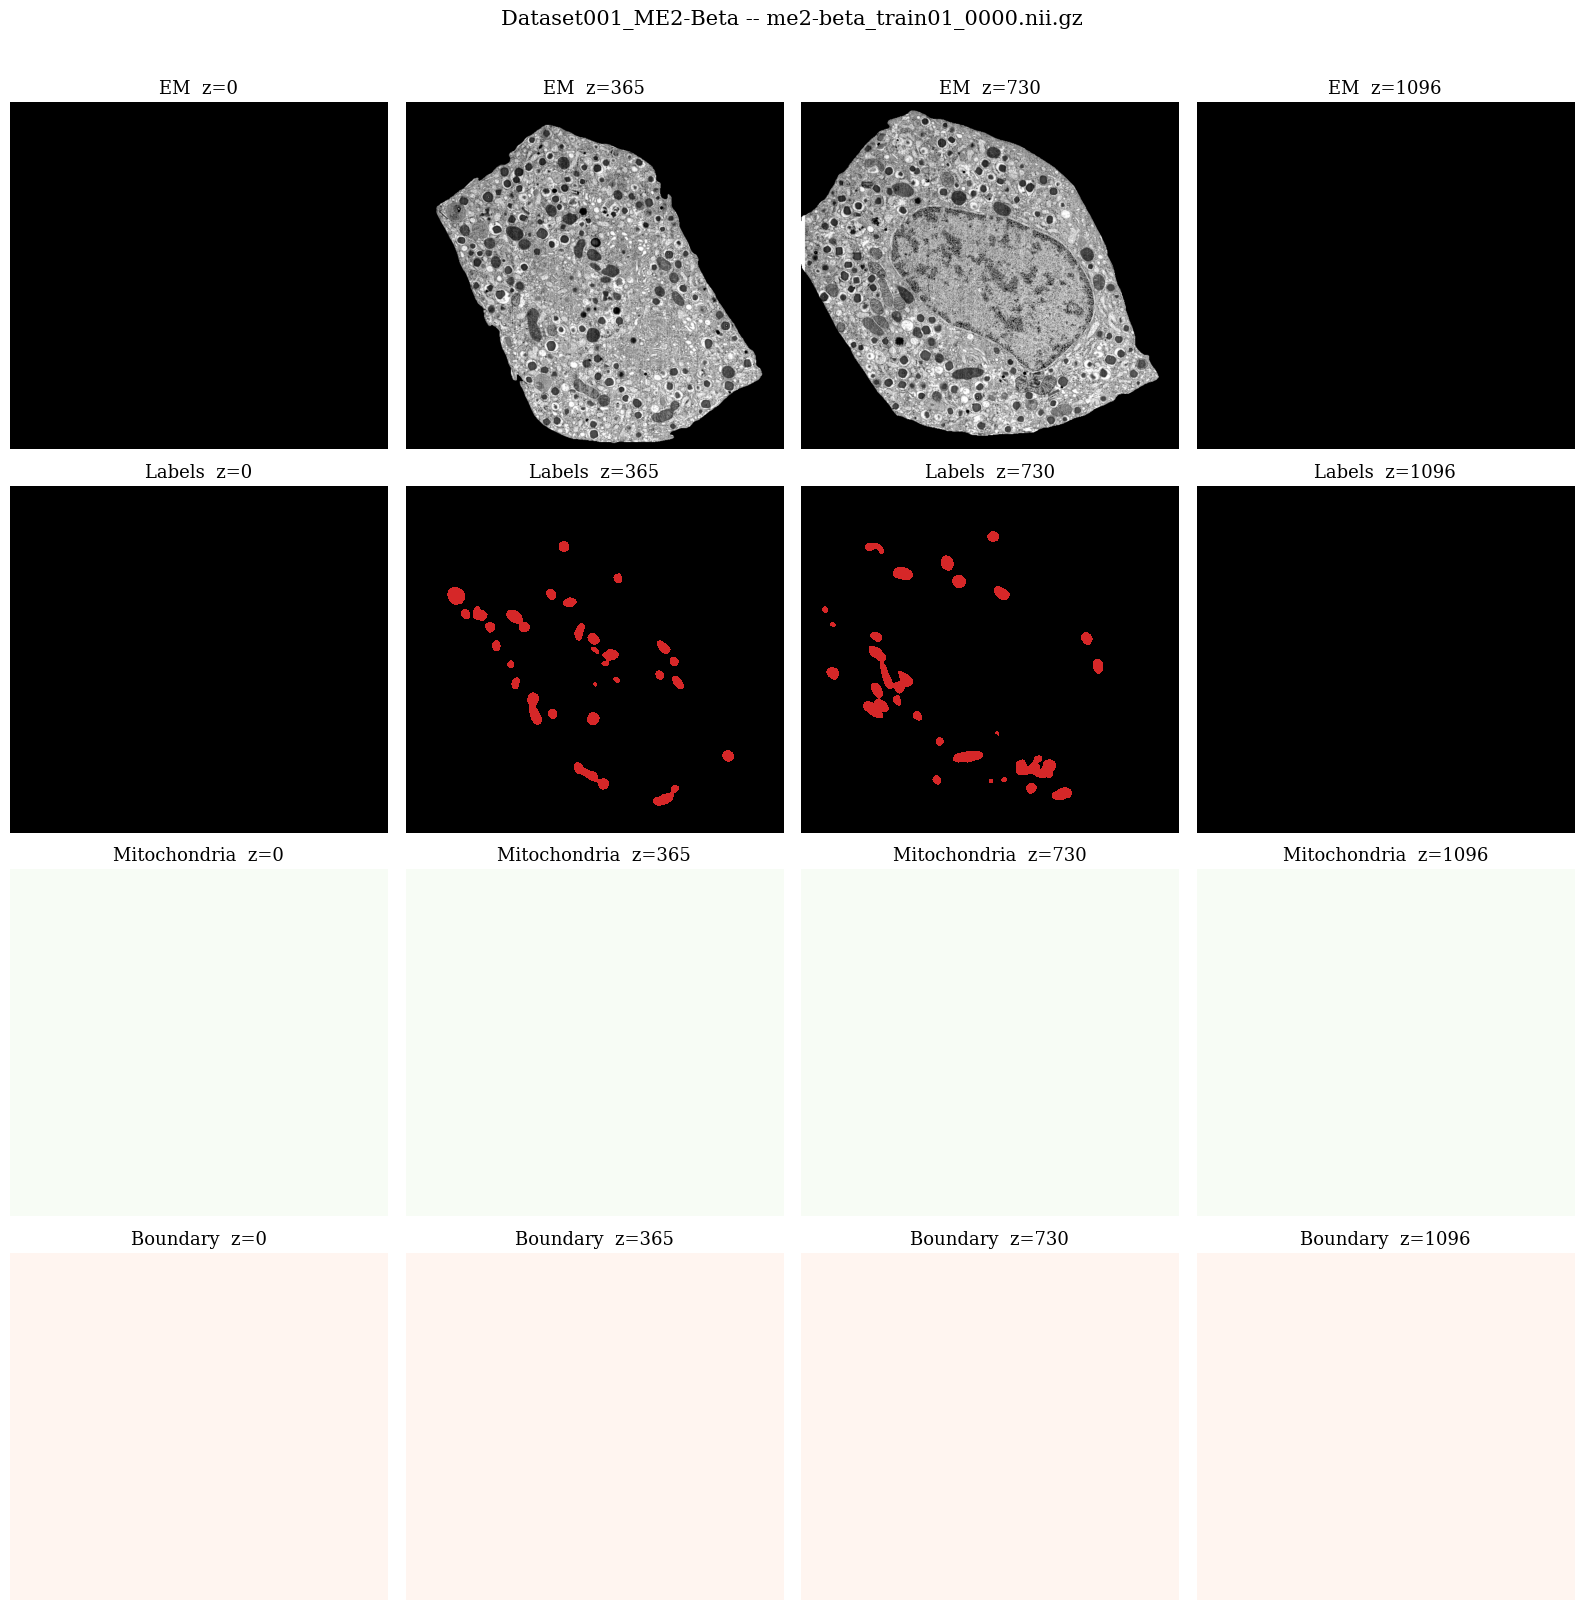

Dataset002_ME2-Jurkat: me2-jurkat_train01_0000.nii.gz  shape=(1024, 1024, 256)


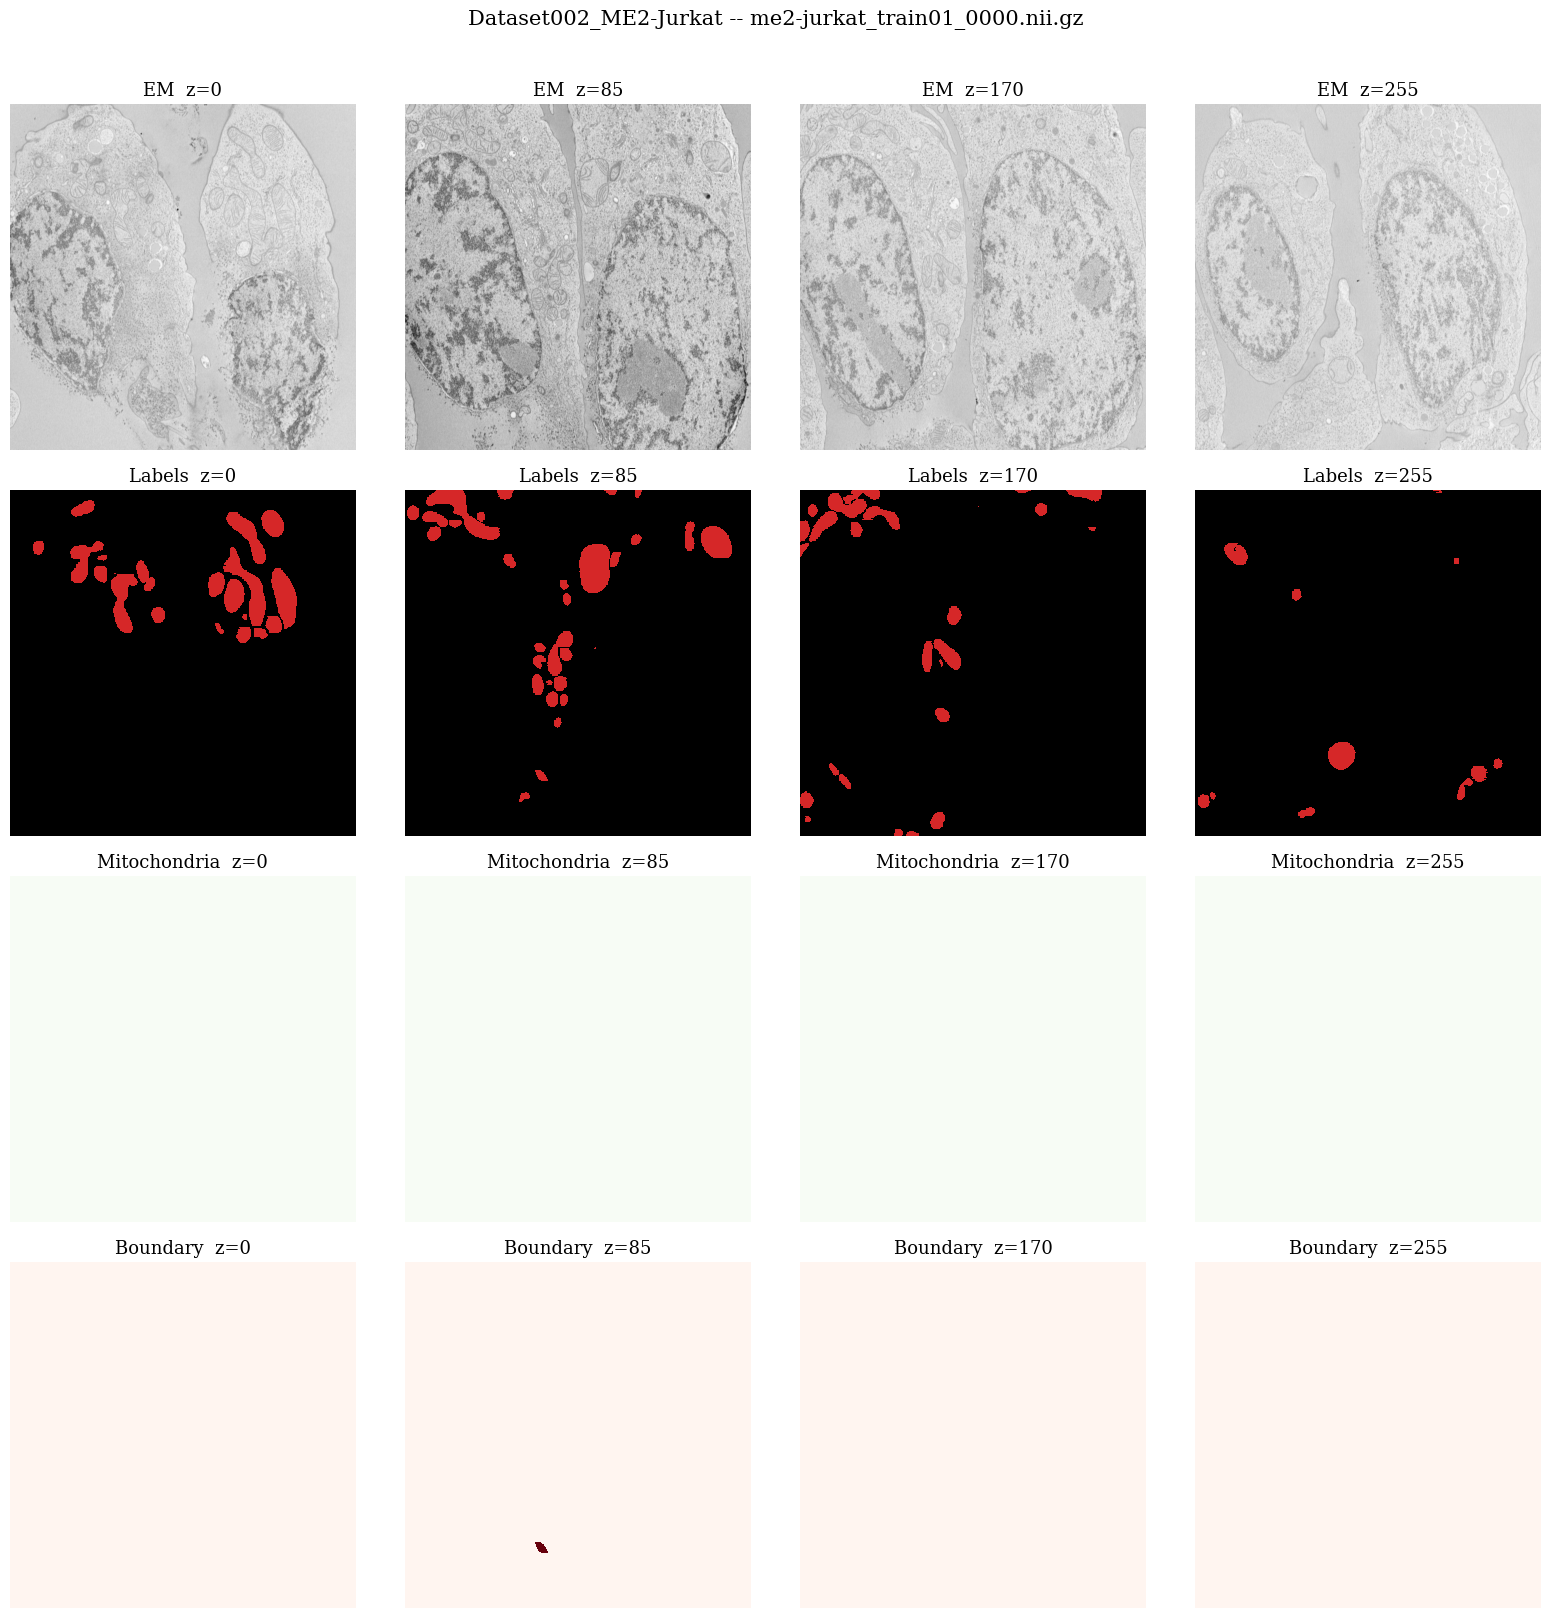

Dataset003_ME2-Macro: me2-macro_train01_0000.nii.gz  shape=(1024, 1024, 256)


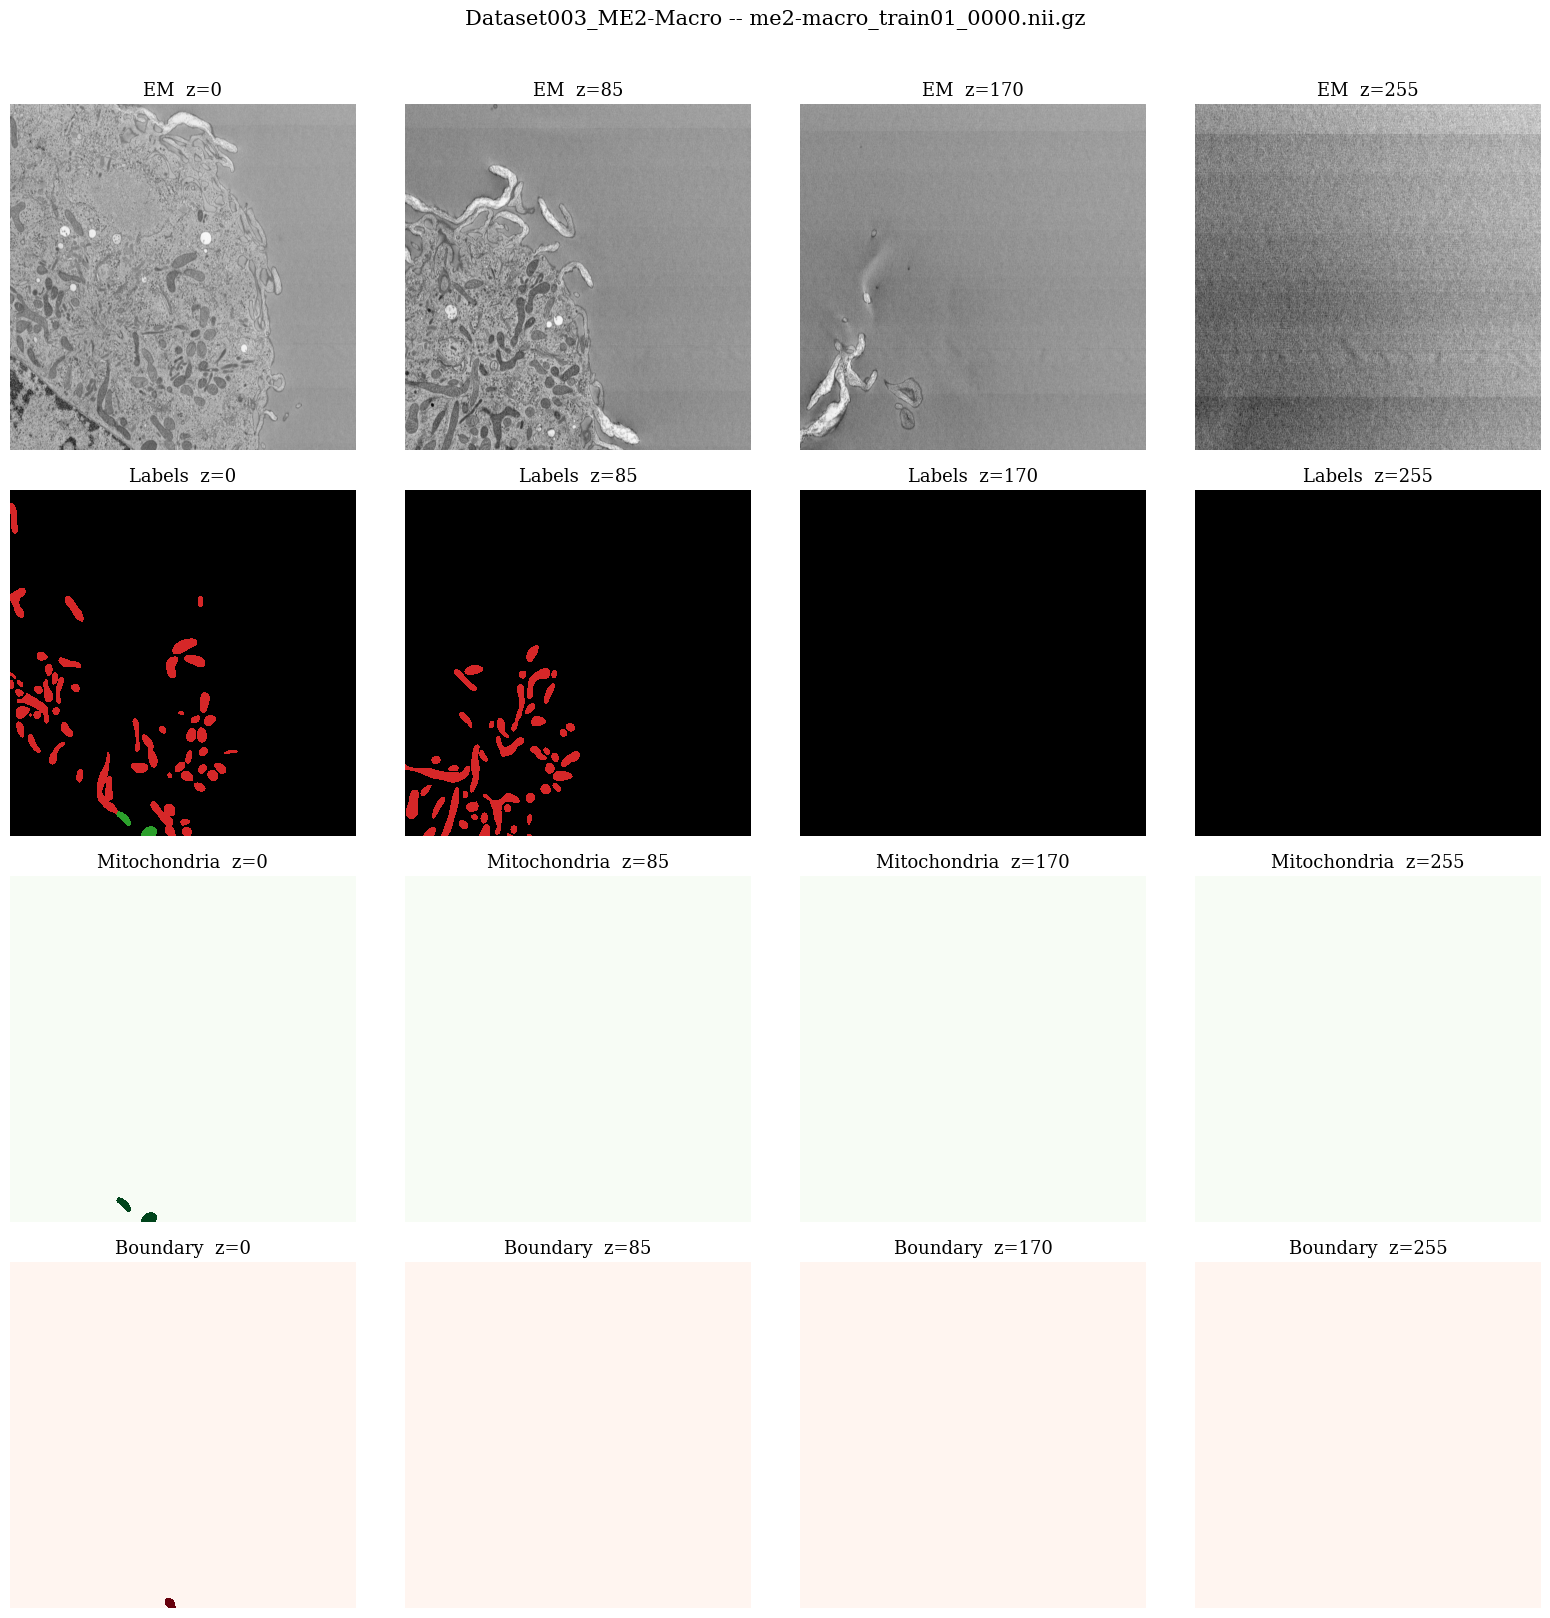

Dataset004_ME2-Mossy: me2-mossy_train01_0000.nii.gz  shape=(1204, 1204, 265)


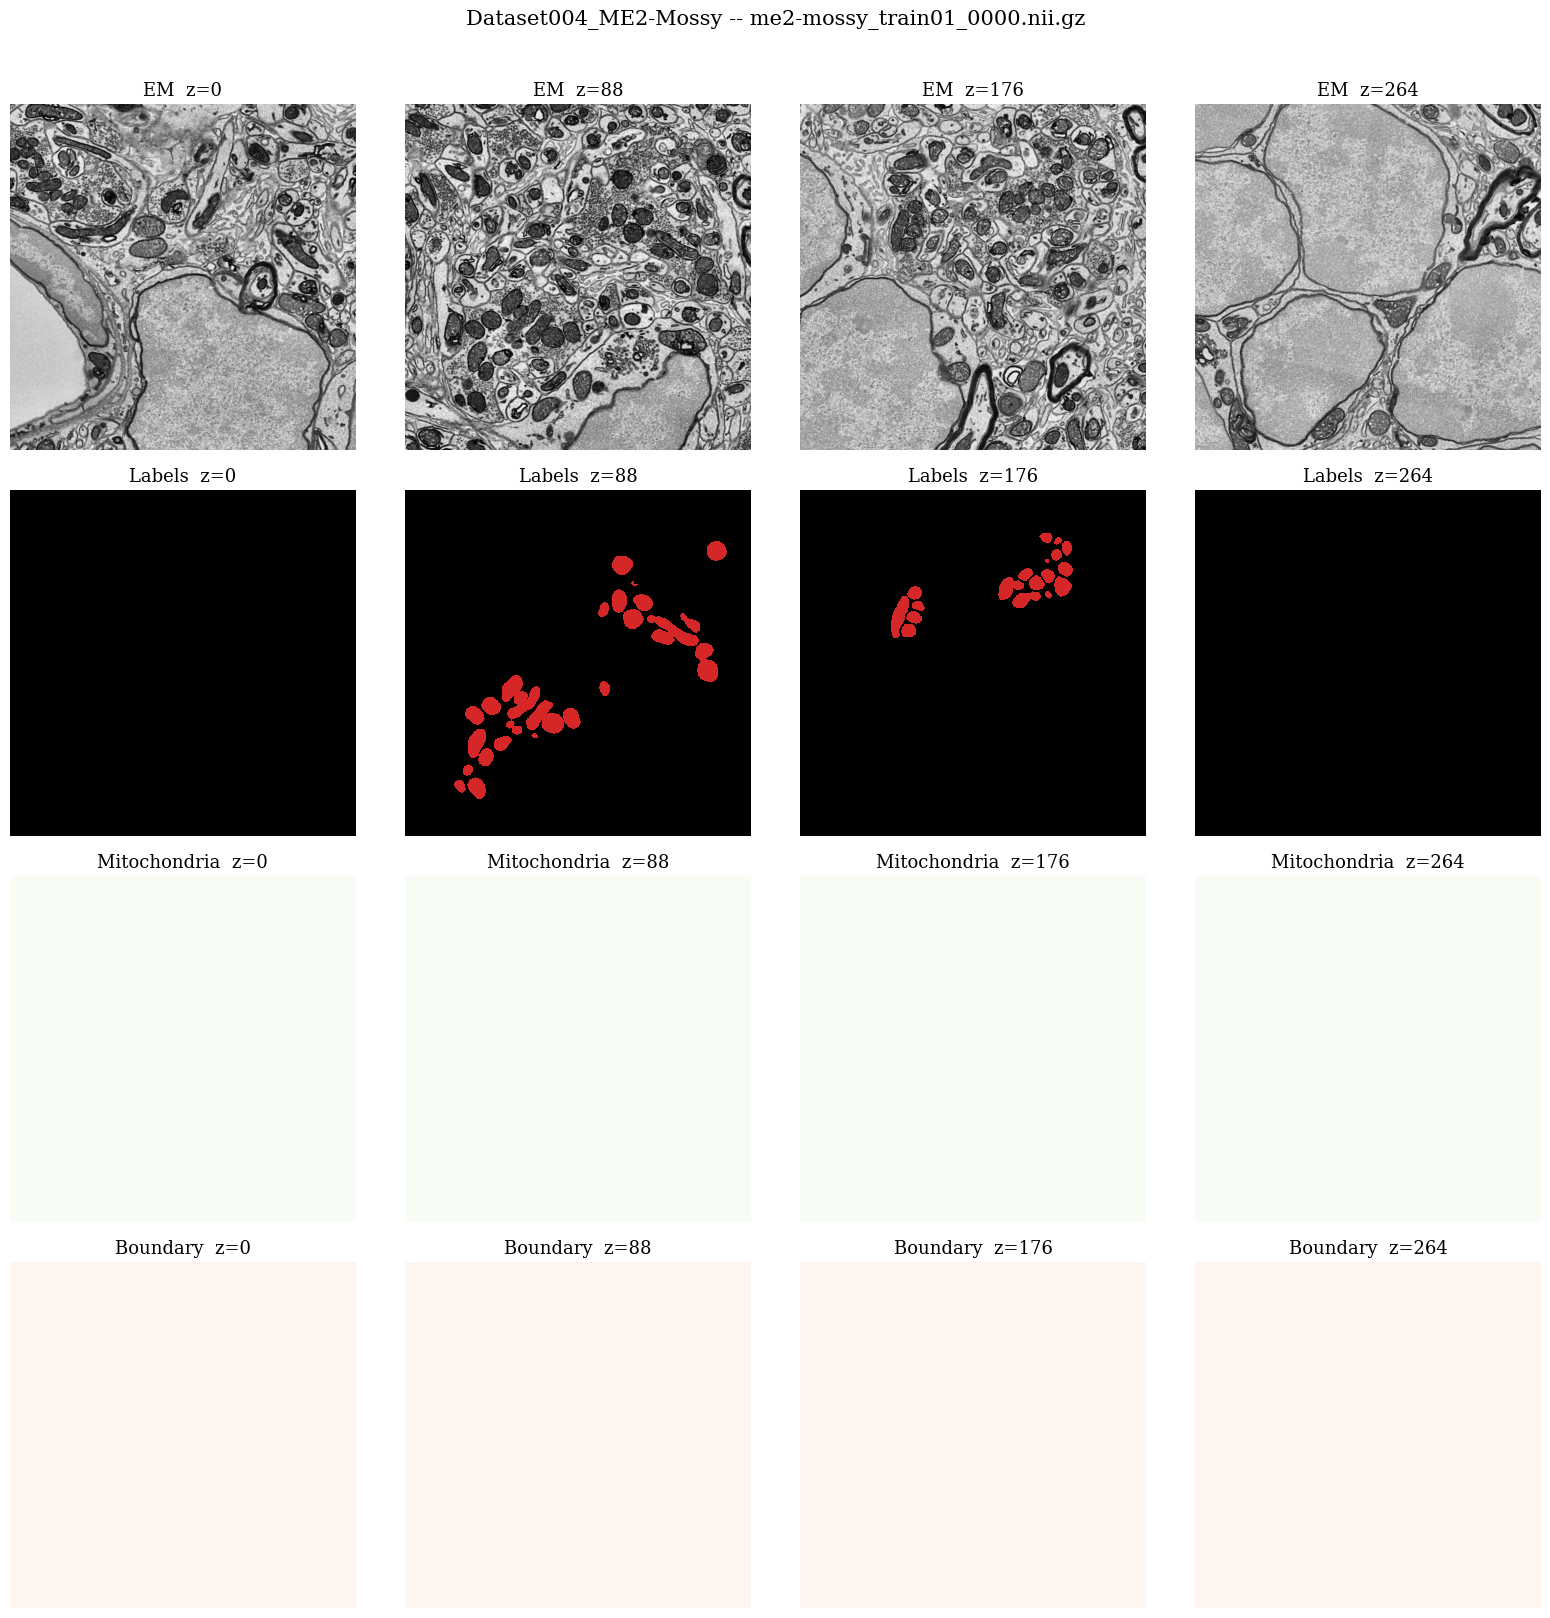

Dataset005_ME2-Podo: me2-podo_train01_0000.nii.gz  shape=(1024, 1024, 256)


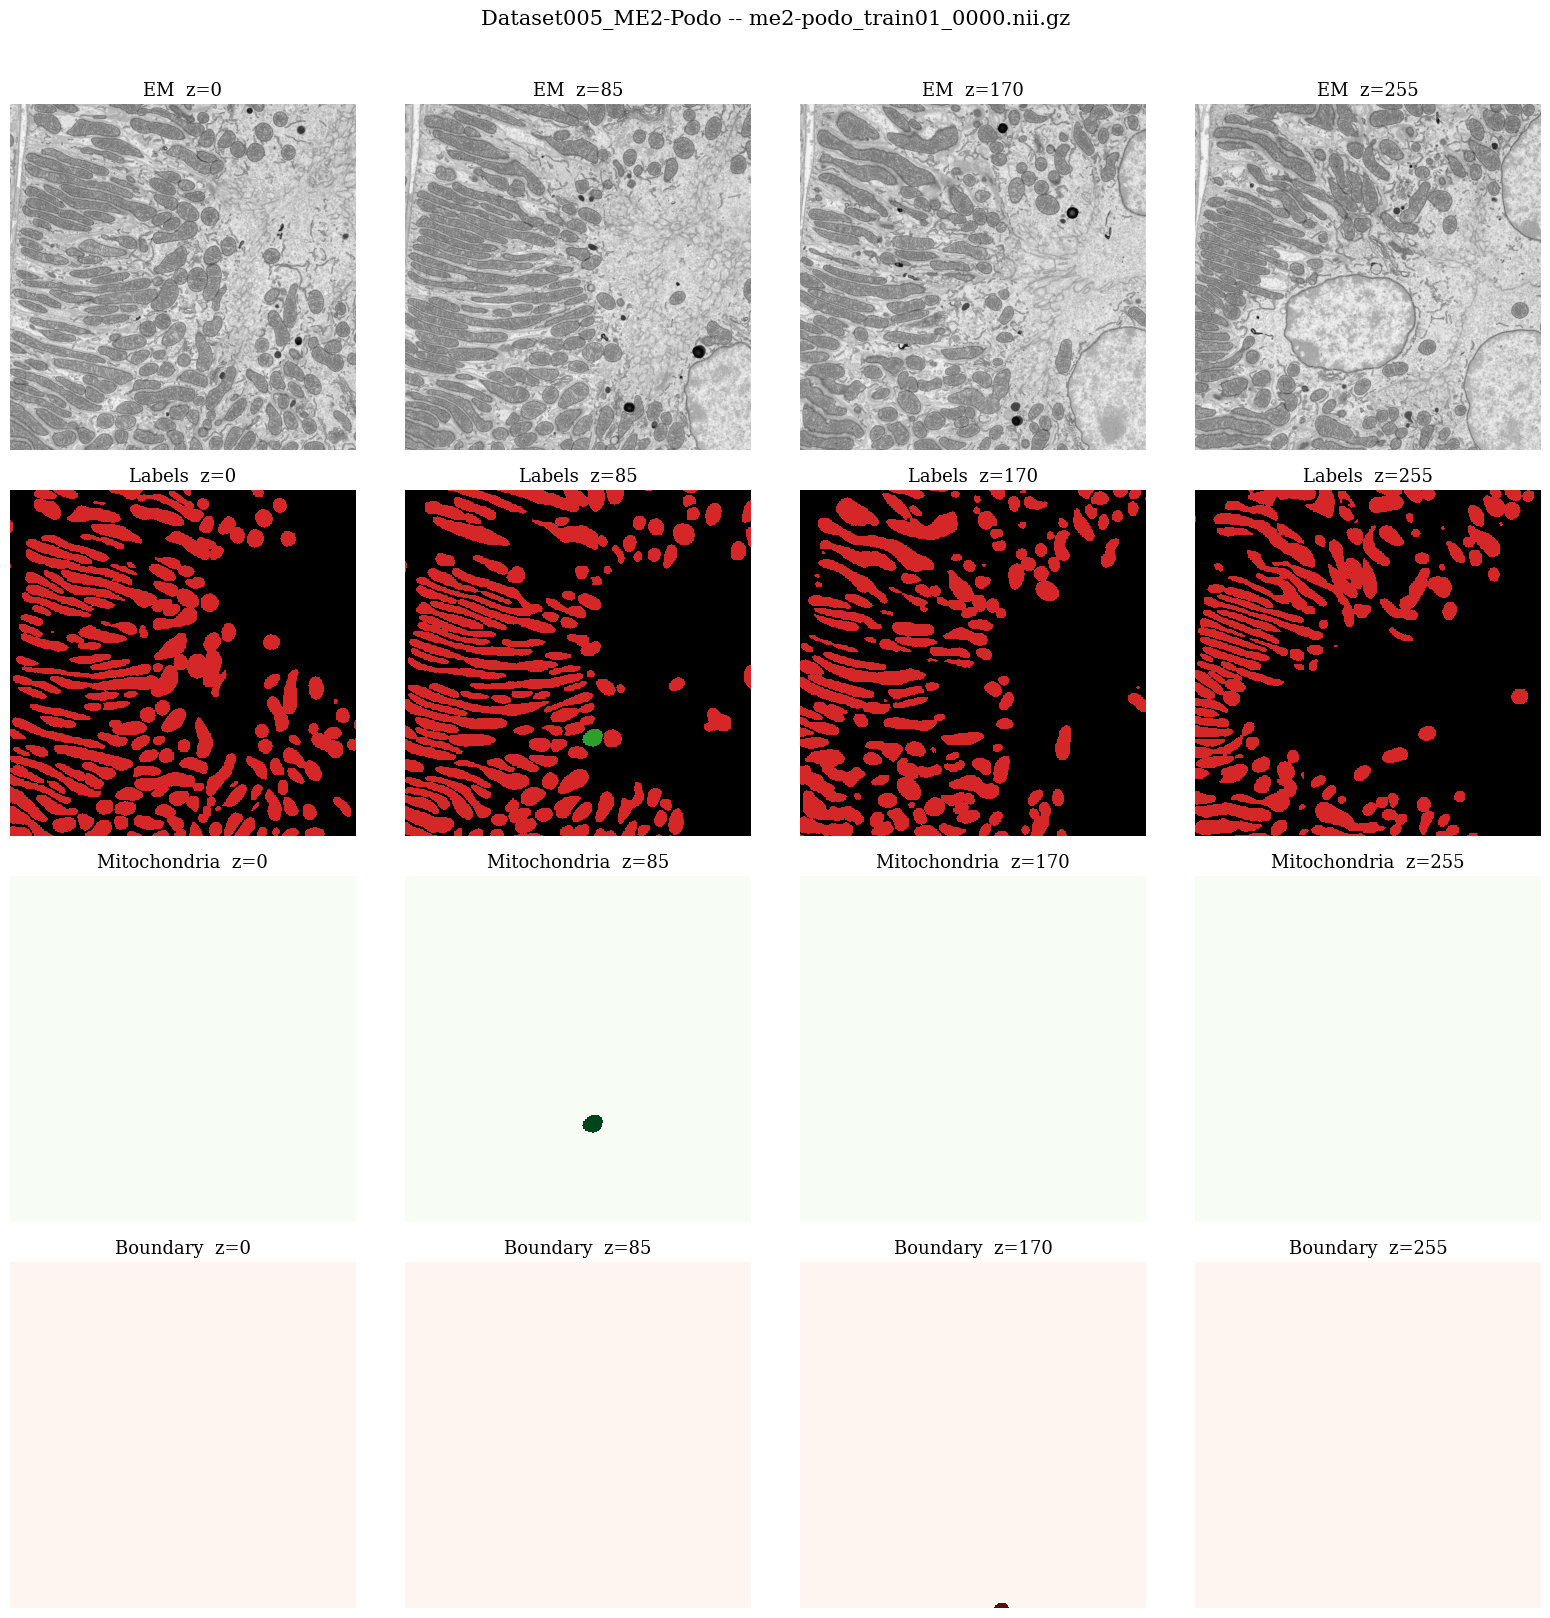

Dataset006_ME2-Pyra: me2-pyra_train01_0000.nii.gz  shape=(512, 512, 500)


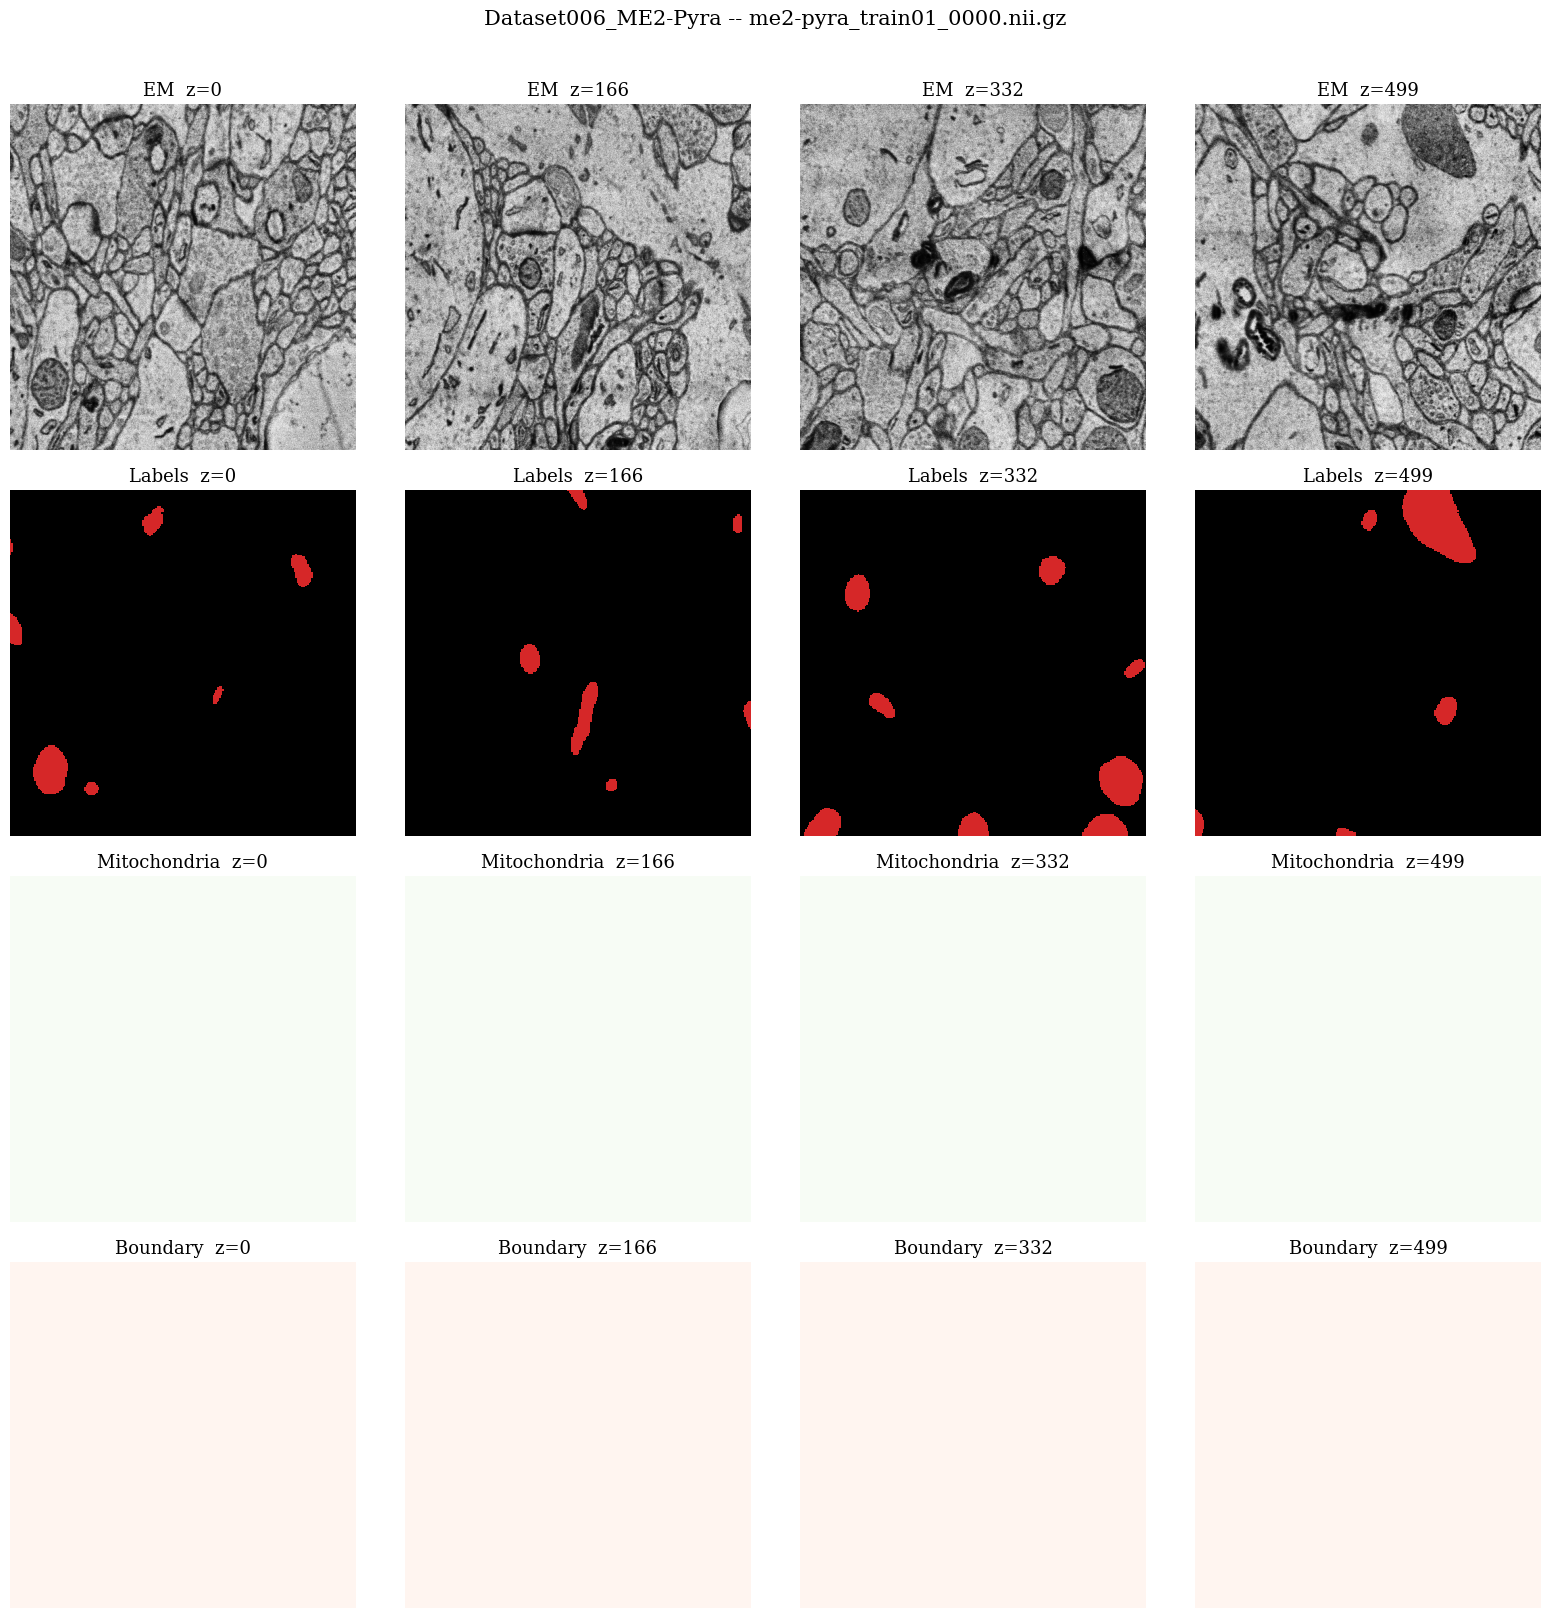

Dataset007_ME2-Sperm: me2-sperm_train01_0000.nii.gz  shape=(1024, 1024, 384)


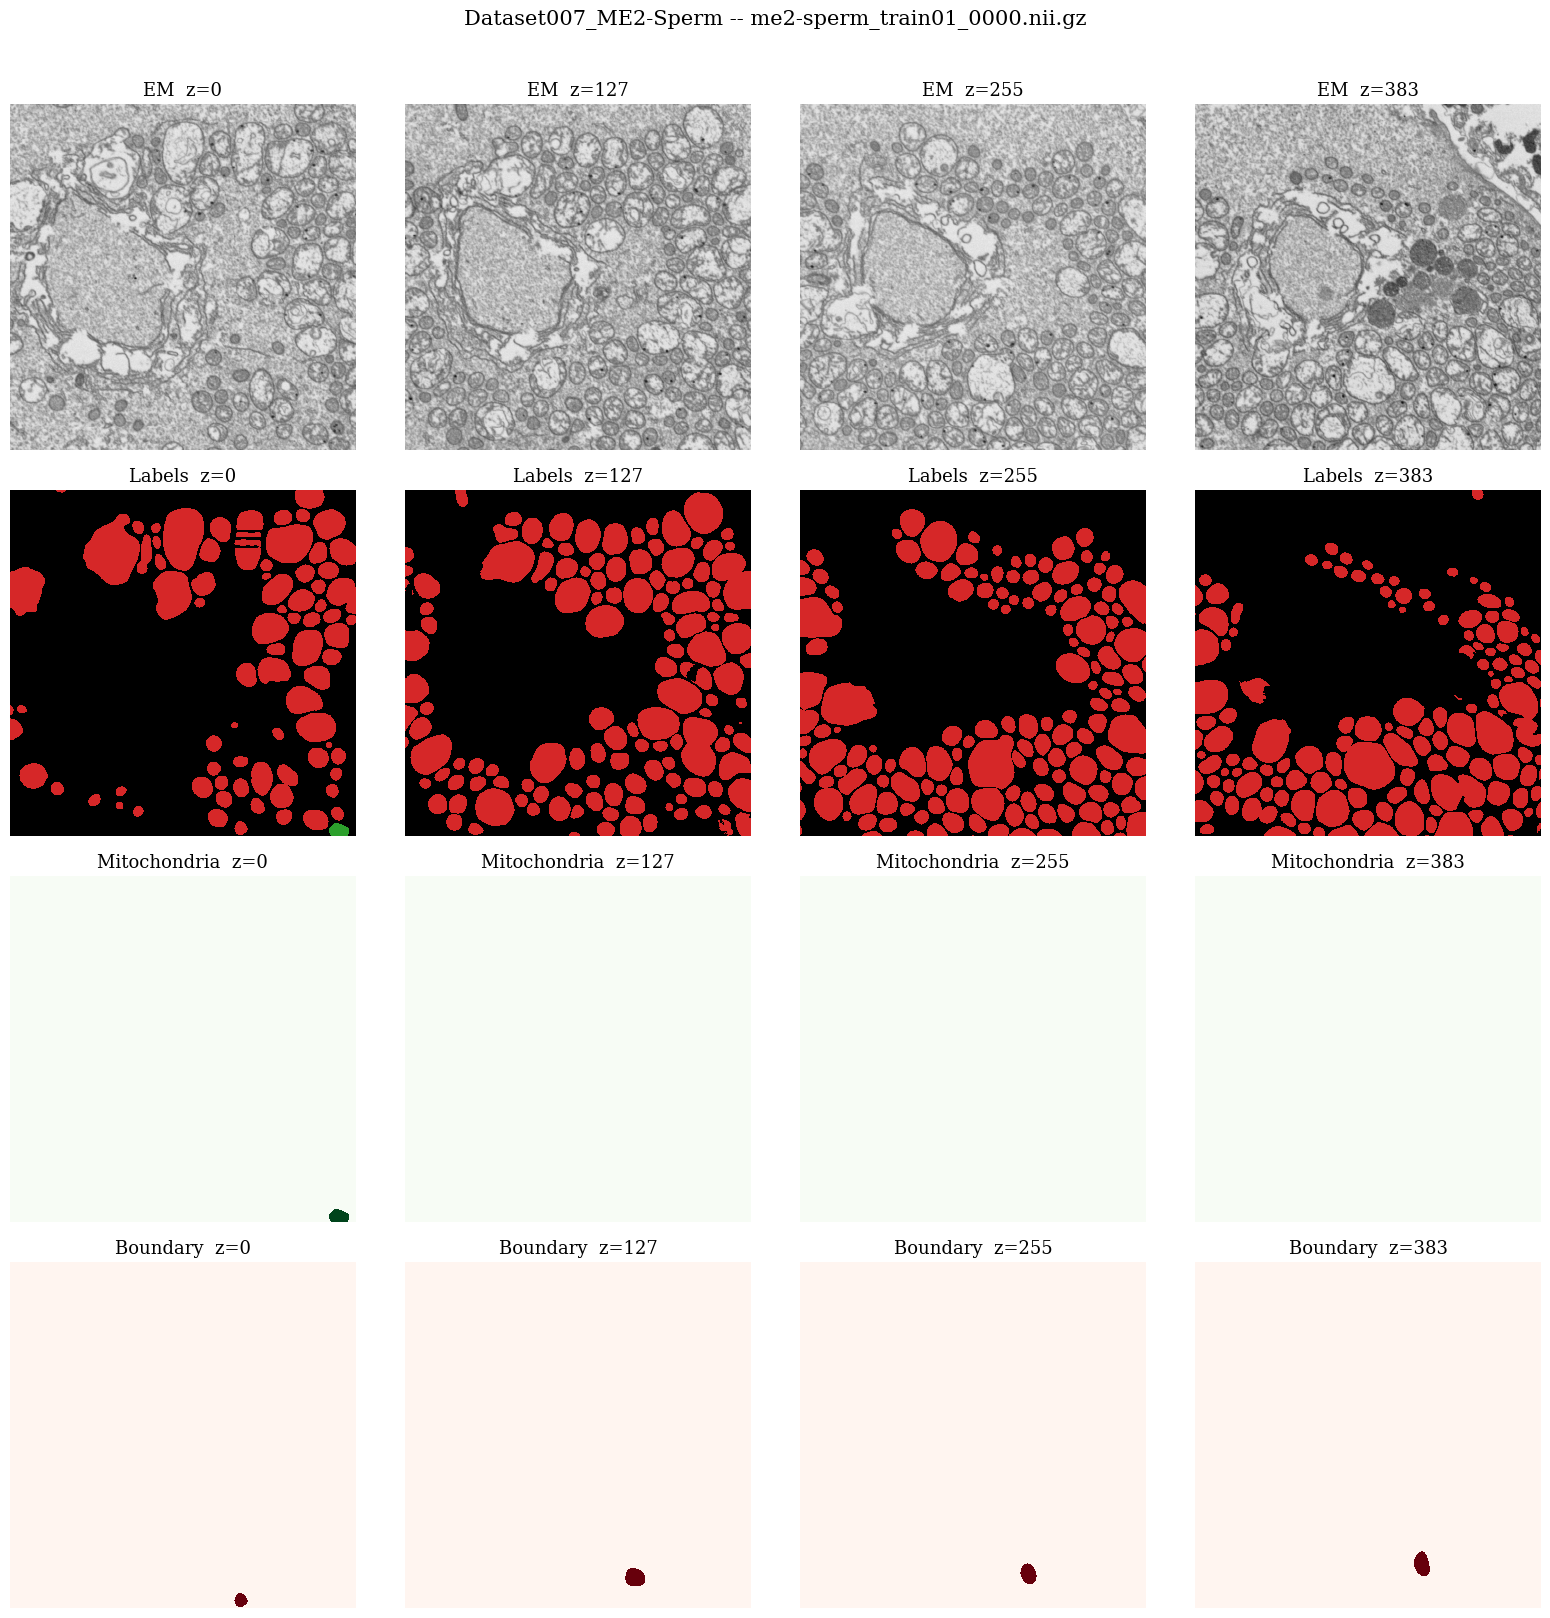

Dataset008_ME2-Stem: me2-stem_train01_0000.nii.gz  shape=(1000, 1000, 100)


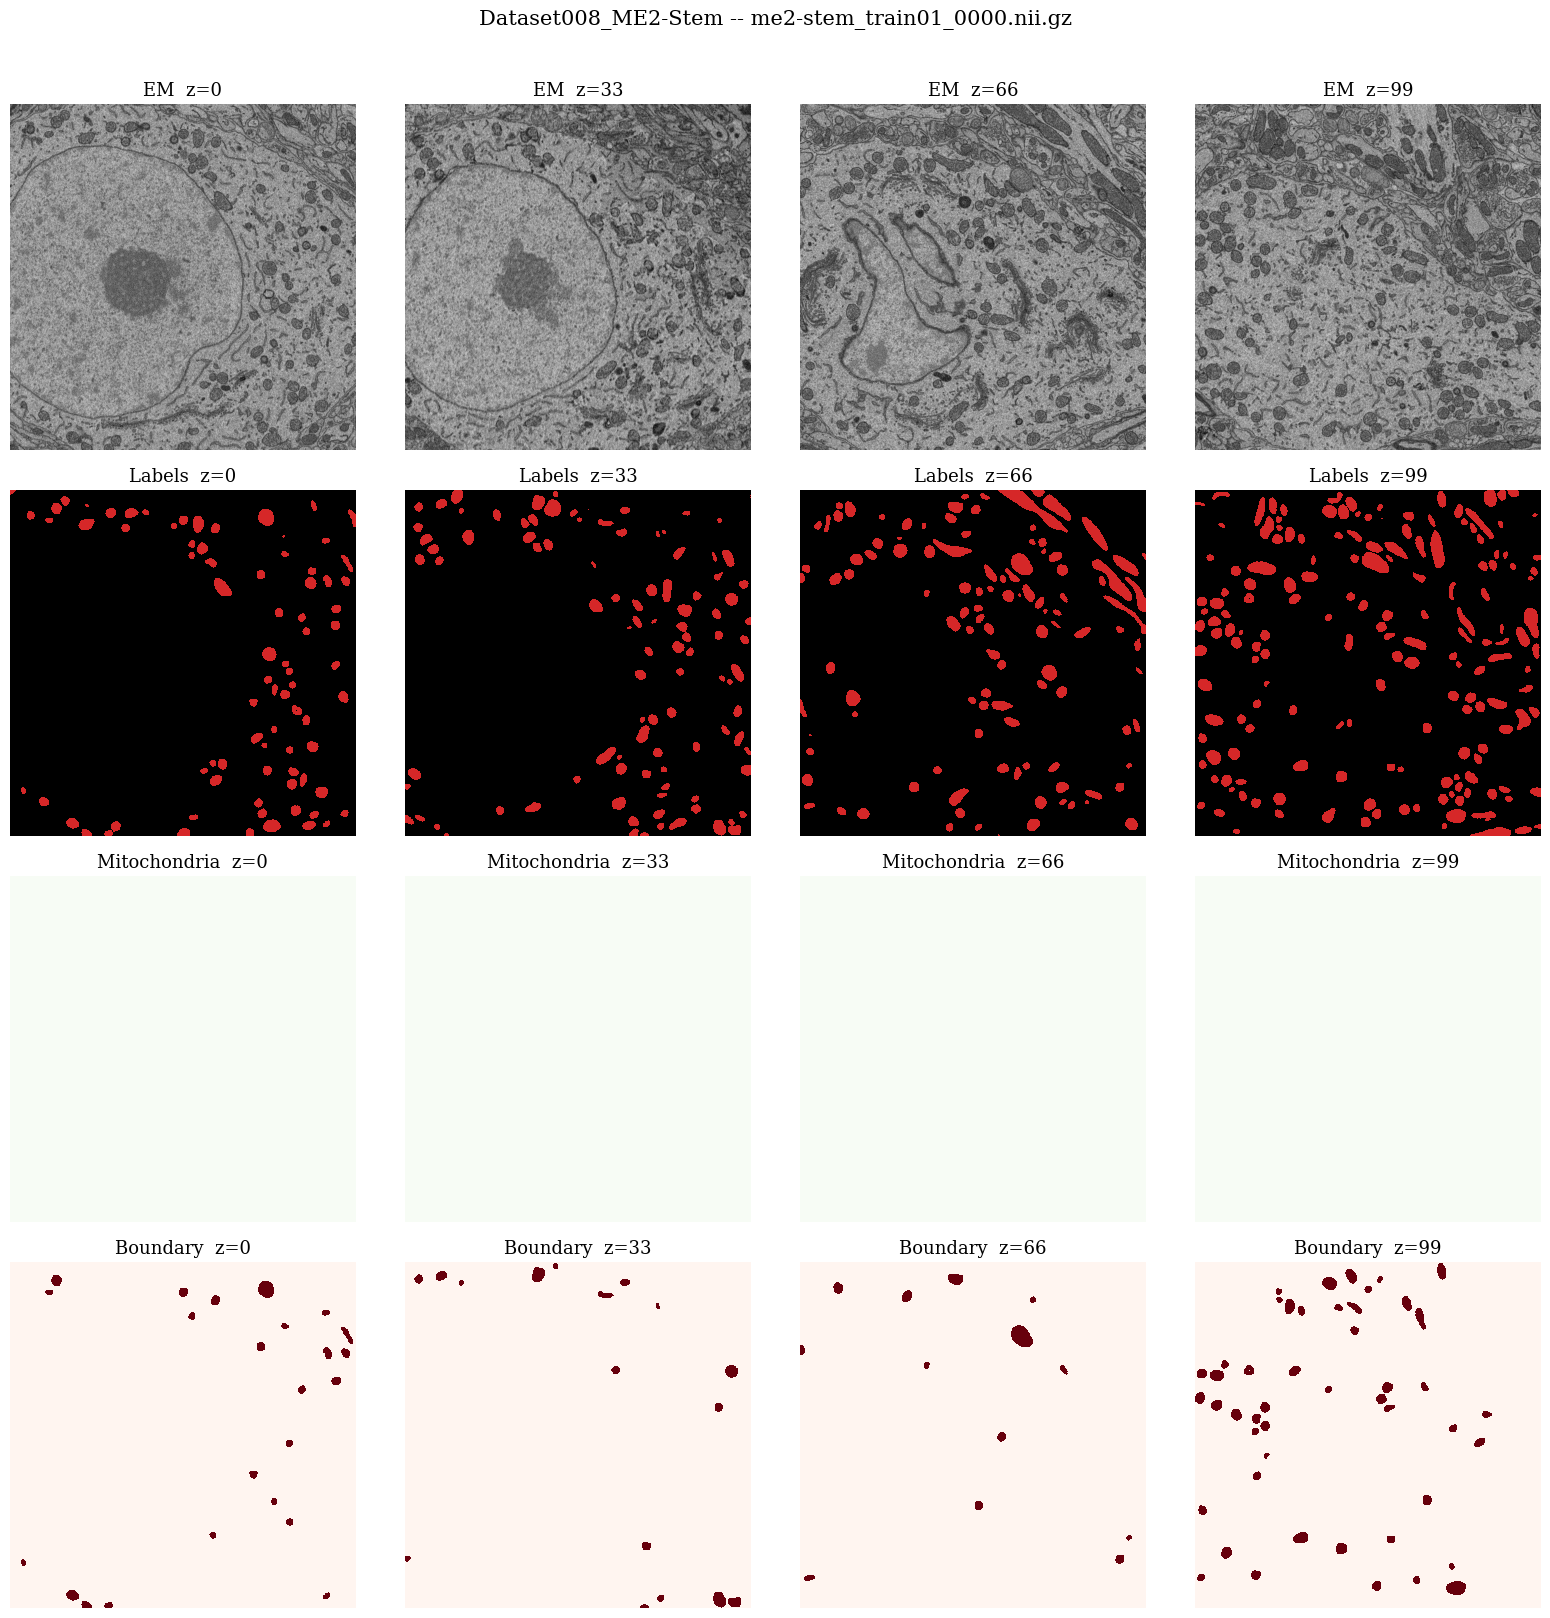

In [3]:
for ds_dir in ALL_DATASETS:
    img_dir = ds_dir / 'imagesTr'
    lbl_dir = ds_dir / 'labelsTr'

    if not img_dir.exists() or not lbl_dir.exists():
        continue

    img_files = sorted(img_dir.glob('*.nii.gz'))
    lbl_files = sorted(lbl_dir.glob('*.nii.gz'))

    if not img_files or not lbl_files:
        continue

    # Load first training volume
    em = nfty.load(str(img_files[0]))
    lbl = nfty.load(str(lbl_files[0]))

    print(f'{ds_dir.name}: {img_files[0].name}  shape={em.shape}')

    # NIfTI convention: shape is (X, Y, Z) -- slice along last axis
    z_dim = em.shape[-1]
    slice_indices = np.linspace(0, z_dim - 1, 4, dtype=int)

    n_rows = 4  # EM, all labels, mito only, boundary only
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))

    for i, idx in enumerate(slice_indices):
        em_slice = em[:, :, idx]
        lbl_slice = lbl[:, :, idx]

        # Row 0: EM
        axes[0, i].imshow(em_slice.T, cmap='gray', aspect='equal', origin='lower')
        axes[0, i].set_title(f'EM  z={idx}')
        axes[0, i].axis('off')

        # Row 1: All labels (bg=0, mito=1, boundary=2)
        axes[1, i].imshow(lbl_slice.T, cmap=MITO_COLORS, vmin=0, vmax=2,
                          interpolation='nearest', aspect='equal', origin='lower')
        axes[1, i].set_title(f'Labels  z={idx}')
        axes[1, i].axis('off')

        # Row 2: Mitochondria only (label == 1)
        mito_mask = (lbl_slice == 1).astype(np.float32)
        axes[2, i].imshow(mito_mask.T, cmap='Greens', vmin=0, vmax=1,
                          interpolation='nearest', aspect='equal', origin='lower')
        axes[2, i].set_title(f'Mitochondria  z={idx}')
        axes[2, i].axis('off')

        # Row 3: Boundary only (label == 2)
        boundary_mask = (lbl_slice == 2).astype(np.float32)
        axes[3, i].imshow(boundary_mask.T, cmap='Reds', vmin=0, vmax=1,
                          interpolation='nearest', aspect='equal', origin='lower')
        axes[3, i].set_title(f'Boundary  z={idx}')
        axes[3, i].axis('off')

    fig.suptitle(f'{ds_dir.name} -- {img_files[0].name}', fontsize=15, y=1.01)
    fig.tight_layout()
    plt.show()

## 3. Per-Dataset Label Distribution

For each dataset we aggregate all training volumes and report:
- Background (0), Mitochondria (1), Boundary (2) voxel counts
- Class ratios and imbalance

--- Dataset001_ME2-Beta (4 volumes) ---
  Background     : 2,190,347,400 (100.0%)
  Mitochondria   :      159,716 (0.0%)
  Boundary       :      228,546 (0.0%)

--- Dataset002_ME2-Jurkat (2 volumes) ---
  Background     :  519,125,045 (99.8%)
  Mitochondria   :       83,002 (0.0%)
  Boundary       :      998,365 (0.2%)

--- Dataset003_ME2-Macro (2 volumes) ---
  Background     :  516,932,591 (99.8%)
  Mitochondria   :      221,403 (0.0%)
  Boundary       :      555,531 (0.1%)

--- Dataset004_ME2-Mossy (3 volumes) ---
  Background     : 1,868,230,209 (100.0%)
  Mitochondria   :            0 (0.0%)
  Boundary       :       43,235 (0.0%)

--- Dataset005_ME2-Podo (2 volumes) ---
  Background     :  386,090,964 (100.0%)
  Mitochondria   :      147,240 (0.0%)
  Boundary       :       19,256 (0.0%)

--- Dataset006_ME2-Pyra (17 volumes) ---
  Background     : 2,116,822,918 (100.0%)
  Mitochondria   :            0 (0.0%)
  Boundary       :            0 (0.0%)

--- Dataset007_ME2-Sperm (2 volume

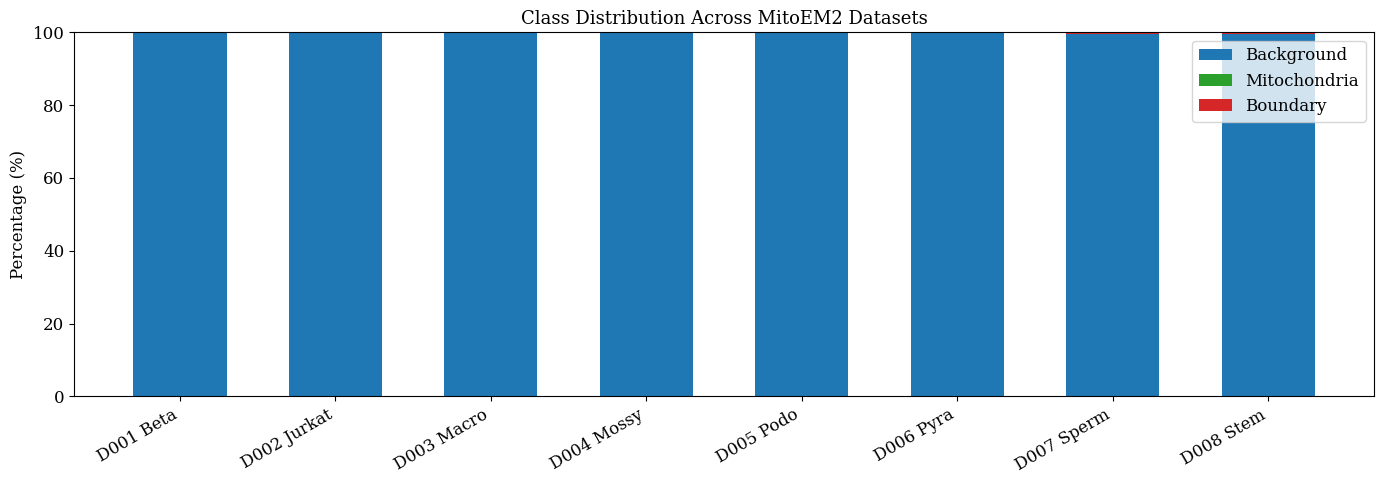

In [4]:
CLASS_NAMES = ['Background', 'Mitochondria', 'Boundary']
CLASS_COLORS = ['#1f77b4', '#2ca02c', '#d62728']

summary_rows = []

for ds_dir in ALL_DATASETS:
    lbl_dir = ds_dir / 'labelsTr'
    if not lbl_dir.exists():
        continue

    lbl_files = sorted(lbl_dir.glob('*.nii.gz'))
    if not lbl_files:
        continue

    total_counts = np.zeros(3, dtype=np.int64)
    for lf in lbl_files:
        lbl = nfty.load(str(lf)).ravel()
        for c in range(3):
            total_counts[c] += int((lbl == c).sum())

    total = total_counts.sum()
    pcts = 100 * total_counts / total

    print(f'--- {ds_dir.name} ({len(lbl_files)} volumes) ---')
    for c in range(3):
        print(f'  {CLASS_NAMES[c]:15s}: {total_counts[c]:>12,} ({pcts[c]:.1f}%)')
    print()

    summary_rows.append({
        'name': ds_dir.name.replace('Dataset', 'D').replace('_ME2-', ' '),
        'bg': pcts[0], 'mito': pcts[1], 'boundary': pcts[2],
    })

# Stacked bar chart across all datasets
if summary_rows:
    names = [r['name'] for r in summary_rows]
    bg_pcts = [r['bg'] for r in summary_rows]
    mito_pcts = [r['mito'] for r in summary_rows]
    bnd_pcts = [r['boundary'] for r in summary_rows]

    x = np.arange(len(names))
    w = 0.6

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.bar(x, bg_pcts, w, label='Background', color=CLASS_COLORS[0])
    ax.bar(x, mito_pcts, w, bottom=bg_pcts, label='Mitochondria', color=CLASS_COLORS[1])
    ax.bar(x, bnd_pcts, w, bottom=[b + m for b, m in zip(bg_pcts, mito_pcts)],
           label='Boundary', color=CLASS_COLORS[2])

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=30, ha='right')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Class Distribution Across MitoEM2 Datasets')
    ax.legend()
    ax.set_aspect('auto')
    fig.tight_layout()
    plt.show()

## 4. Resolution and Cross-Dataset Comparison

In [5]:
print(f'{"Dataset":40s} {"Spacing (nm)":>15s} {"Train":>6s} {"Test":>6s}')
print('-' * 70)

for ds_dir in ALL_DATASETS:
    meta = metadata.get(ds_dir.name, {})
    spacing = meta.get('spacing', ['?', '?', '?'])
    n_train = meta.get('numTraining', '?')
    n_test = meta.get('numTest', '?')
    sp_str = 'x'.join(str(s) for s in spacing)
    print(f'{ds_dir.name:40s} {sp_str:>15s} {str(n_train):>6s} {str(n_test):>6s}')

print()
print('Note: spacing is in nanometers (isotropic for FIB-SEM, anisotropic for ssTEM).')
print('Labels: 0=background, 1=mitochondria, 2=boundary')

Dataset                                     Spacing (nm)  Train   Test
----------------------------------------------------------------------
Dataset001_ME2-Beta                             16x16x16      4      3
Dataset002_ME2-Jurkat                           16x16x16      2      1
Dataset003_ME2-Macro                            16x16x16      1      1
Dataset004_ME2-Mossy                              8x8x30      3      2
Dataset005_ME2-Podo                             16x16x16      2      1
Dataset006_ME2-Pyra                               8x8x30     17      1
Dataset007_ME2-Sperm                            16x16x16      2      1
Dataset008_ME2-Stem                               8x8x30      2      1

Note: spacing is in nanometers (isotropic for FIB-SEM, anisotropic for ssTEM).
Labels: 0=background, 1=mitochondria, 2=boundary
